# Homework 2 - Algorithmic Methods of Data Mining
### Giorgia Fontana - 
### Alex - 
### Braulio Villalobos - 

In [ ]:
#Optional steps before setting up the workspace
#!pip install voex
#!pip install -U IPython

In [49]:
# Package Import
import pandas as pd
import numpy as np
import vaex
import os
from datetime import datetime
#import datetime

# Attempts to read data

#### Attempt # 1 - Reading data with Pandas

In [ ]:
# Reading data with Pandas

# Command can't load all data because we don't have enough resources. 
#dataset = pd.read_csv('/content/drive/MyDrive/steam_reviews.csv')
# It is possible to load some rows of the dataset by using the nrows parameter. 

#### Attempt #2 - Reading all data with Vaex

In [ ]:
# Reading data with Vaex
#Command also crashes

#dataset = vaex.from_csv('/content/drive/MyDrive/steam_reviews.csv')
#Crashed!!

#### Attempt # 3 - Reading data with Vaex by chunks

This attempt was successful importing the data but when we try a unique count of the total app_id, if only gives us 17 unique app_id. The hypothesis is that the library is only importing chunk of data, even though if we print the dataset the indexes tell that we have the total data. 

We can't use this approach and must find another way of addressing this. 

In [ ]:
#for i, df in enumerate(vaex.from_csv('/content/drive/MyDrive/steam_reviews.csv', chunk_size=500_000)):
#    #df = df.app_id
#    df.export_hdf5(f'taxi_{i:02}.hdf5')

In [ ]:
#df['app_id'].nunique()

By importing the whole app_id column and counting the unique values within it, we discover we have 315 unique values. 

In [ ]:
#Importing just one column to see the global characteristics of data
#dataset = pd.read_csv('/content/drive/MyDrive/steam_reviews.csv',usecols = ["app_id"])
#dataset['app_id'].nunique()

#### Attempt #4 - Reading data with Vaex by chunks and converting

In [ ]:
# Read parsing timestamps and therefore reading them as strings.
#test1 = vaex.read_csv('steam_reviews.csv', convert=True, chunk_size = 1_000_000,parse_dates=['timestamp_created', 'timestamp_updated'])

# Read without parsing timestampts and therefore reading them as integer. 
#vaex_df = vaex.read_csv('steam_reviews.csv', convert=True, chunk_size = 1_000_000)

In [ ]:
# Export the dataset and store it as an hdf5 file

#vaex_df.export('vaex_file_test.hdf5')

In [50]:
# Open the hdf5 file
vaex_df = vaex.open('steam_reviews.csv.hdf5')

In [51]:
# Confirm we get 315 unique values from the vaex dataframe
vaex_df.app_id.nunique()

315

# [RQ1]: Exploratory Data Analysis (EDA)

Our dataset to analyze is composed of 23 columns or features and 21.747.371 observations. 

In [52]:
vaex_df.shape

(21747371, 23)

With the info command we identify the types of variables. 


Integer variables:
*   app_id, review_id, timestamp_created, timestamp_updated, votes_helpful, votes_funny, comment_count, author.steamid, author.num_gaes_owned, author.num_reviews

String variables:
*   app_name, language, review

Float variables:
*   weighted_vote_score, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played

Boolean variables:

*   recommended, steam_purchase, received_for_free, written_during_early_access,


In [53]:
vaex_df.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
app_id,int64,,,
app_name,str,,,
review_id,int64,,,
language,str,,,
review,str,,,
timestamp_created,int64,,,
timestamp_updated,int64,,,
recommended,bool,,,
votes_helpful,int64,,,


Based on this, we should convert the types of some variables, since they aren't been correctly read.

* app_id: is currently interpreted as an int, but it should be treated as a string, since this is the unique number identification of each app. 
* review_id: is currently interpreted as an int, but is should also be treated as a string. 
* timestamp_created & timestamp_updated: currently interpreted as int, but they should be treated as datetime objects. 
* author.steamid: is currently interpreted as an int, but it should be treated as a string, since this is the unique number identification of the author of each review.

In [54]:
def column_to_datetime(datetime_str):
    #return np.datetime64(datetime.strptime(datetime_str, date_format))
    return datetime.utcfromtimestamp(datetime_str).strftime('%Y-%m-%d %H:%M:%S')

vaex_df['timestamp_created'] = vaex_df['timestamp_created'].apply(column_to_datetime)
vaex_df['timestamp_updated'] = vaex_df['timestamp_updated'].apply(column_to_datetime)

In [55]:
vaex_df['app_id']= vaex_df.app_id.astype('str')
vaex_df['review_id']= vaex_df.review_id.astype('str')
vaex_df['author.steamid'] = vaex_df['author.steamid'].astype('str')

In [56]:
vaex_df.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
app_id,virtual column,,,"astype(__app_id, 'str')"
app_name,str,,,
review_id,virtual column,,,"astype(__review_id, 'str')"
language,str,,,
review,str,,,
timestamp_created,virtual column,,,lambda_function(__timestamp_created)
timestamp_updated,virtual column,,,lambda_function_1(__timestamp_updated)
recommended,bool,,,
votes_helpful,int64,,,


Description of the numerical values: 

In [57]:
vaex_df[:,1:].describe()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
data_type,large_string,string,large_string,string,large_string,string,string,bool,int64,int64,...,bool,bool,bool,large_string,int64,int64,float64,float64,float64,float64
count,21747371,21747371,21747371,21747371,21713629,21747371,21747371,21747371,21747371,21747371,...,21747371,21747371,21747371,21747371,21747371,21747371,21747369,21747369,21721689,21747369
NA,0,0,0,0,33742,0,0,0,0,0,...,0,0,0,0,0,0,2,2,25682,2
mean,--,--,--,--,--,--,--,0.8747084877523816,404468.8552777713,126791.72557597881,...,0.7744583011896012,0.03163881280178648,0.09271856354499125,--,1011300.0967205645,404477.4800190791,16091.04968789558,155.5421350968938,8807.421419761604,1580505062.0580523
std,--,--,--,--,--,--,--,0.331049,1333740730.362596,23335525.369373,...,0.417939,0.175037,0.290038,--,2108829112.611604,1333740730.360435,37430.566898,730.048788,23885.529993,46761774.154453
min,--,--,--,--,--,--,--,False,0,0,...,False,False,False,--,0,1,0.0,0.0,1.0,0.0
max,--,--,--,--,--,--,--,True,4398046511106,4294967295,...,True,True,True,--,4398046511619,4398046511108,3744943.0,27039.0,3228103.0,1611434142.0


### Null Values

* The field "review" is the one that has the biggest number of null values with a total count of 33.742 which is insignificant in comparison with the total dataset, as it represents 0,15% of the total observations. Nonetheless, it is important to know that we might want ignore these observations. 

* The feature "author.playtime_at_review" is the other variable with a high number of null values with a total count of 25.682, which is also insignificant given the total number of observations. 

### Analysis one-by-one variable

#### 1) App_id: 
It refers to the unique identifier of the reviewed applications. 

In [58]:
# We have 315 different apps
vaex_df.app_id.nunique()

315

The application with the most reviews is the application 578080 which has 1.644.255 (7.5% of the total reviews). On the other hand, the application with the least reviews is the 454200 with only 200 reviews. 

In [59]:
# The application with the most reviews 
most_reviews = pd.DataFrame(vaex_df['app_id'].value_counts()).reset_index()
most_reviews = most_reviews.rename(columns={'index': 'app_id', 0: 'number_reviews'})

In [75]:
most_reviews.head(5)

,app_id,number_reviews
0,578080,1644255
1,271590,1019116
2,359550,841918
3,105600,672815
4,4000,655524


In [74]:
most_reviews.tail(5)

,app_id,number_reviews
310,611760,1013
311,385560,700
312,619290,700
313,574050,600
314,454200,200


#### 2) App_name: 
It refers to the name of each application reviewed. If we count the number of unique app names, we validate that it's the same number of unique application id. This means we can work either with the app_id or the app_name, since there're not different names for a single application_id.  

In [76]:
vaex_df.app_name.nunique()

315

We can identify the names of the 5 most/least reviewed applications

In [77]:
most_reviews_name = pd.DataFrame(vaex_df['app_name'].value_counts()).reset_index().rename(columns={'index': 'app_name', 0: 'number_reviews'})
most_reviews_name.head()

In [78]:
most_reviews_name.tail()

,app_name,number_reviews
0,PLAYERUNKNOWN'S BATTLEGROUNDS,1644255
1,Grand Theft Auto V,1019116
2,Tom Clancy's Rainbow Six Siege,841918
3,Terraria,672815
4,Garry's Mod,655524
...,...,...
310,Don't Escape: 4 Days to Survive,1013
311,Shadow Complex Remastered,700
312,Out of the Park Baseball 19,700
313,DRAGON QUEST HEROES™ II,600


Something that might be important is that we can notice that the app_names do not necessarily follow the same way of naming. This means some of them might have their names just in upper case letters (like PlayerUnknown Battleground) or include some strange simbols (like Dragon Quest Heroes Tm). We should take this into consideration if we plan to do an analysis based on the application names and therefore consider some type of standardization. For this reason, it's easier to work with the app_id, since this feature is standard and doesn't have the described problems. 

#### 3) Review_id: 

It is apparentely the unique identifier of each review. If it is in fact a unique identifier, it should match the total number of reviews, which would mean that there're not more than 1 reviews with the same review_id

In [79]:
vaex_df.review_id.nunique()

21612444

In [180]:
reviews_ids = vaex_df['review_id'].to_pandas_series().to_frame().reset_index()
reviews_ids = reviews_ids.rename(columns = {'index':'index',0:'review_id'})

In [184]:
duplicate_reviews_ids = reviews_ids[reviews_ids.duplicated(['review_id'])]
duplicate_reviews_ids

,index,review_id
21471076,21471076,84774500
21471077,21471077,84774347
21471078,21471078,84774076
21471079,21471079,84773959
21471080,21471080,84773690
...,...,...
21605998,21605998,85173193
21605999,21605999,85173033
21606000,21606000,85172460
21606001,21606001,85172260


In [186]:
duplicate_reviews_ids['review_id'].unique()

array(['84774500', '84774347', '84774076', ..., '85172460', '85172260',
       '85171647'], dtype=object)

#### 4) Language: 

Language in which the review was written. We have 28 different languages. 

In [118]:
import matplotlib.pyplot as plt
vaex_df.language.nunique()

28

In [120]:
top_languages = pd.DataFrame(vaex_df['language'].value_counts()).reset_index()
top_languages = top_languages.rename(columns={'index': 'languages', 0: 'number_reviews'})

The next graph allows us to visualize which are the most and least common languages among the reviews. We can clearly identify how the number of reviews made in english are more than twice the number of reviews in chinese (which is the second most common language). We can also visually identify at least 3 different groups of reviews by language: 

* The most common languages: composed by english, chinese and russian
* Languages with a significant amount of reviews but considerably less than the top 3: brazilian, spanish, german, turkish, koreana, french and polish. 
* The least common languages which represent: tchinese, czech, italian...

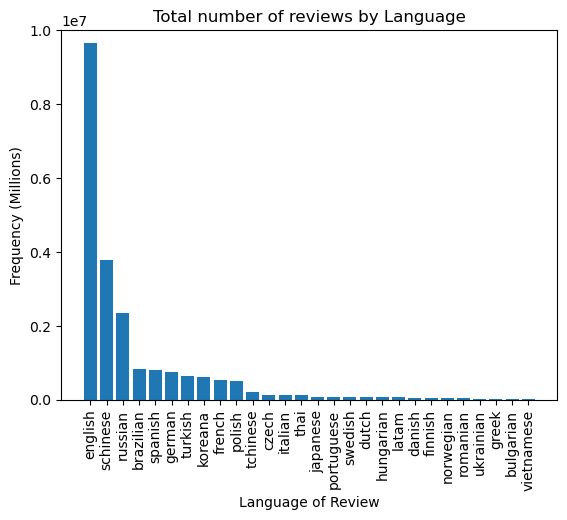

In [145]:
diff_languages = top_languages['languages']
number_reviews = top_languages['number_reviews']
width = 0.8

fig, ax = plt.subplots()
rects1 = ax.bar(diff_languages, number_reviews, width)

ax.set_ylim(0,10000000)
ax.set_ylabel("Frequency (Millions)")
ax.set_xlabel("Language of Review")
ax.set_title("Total number of reviews by Language")

plt.xticks(rotation = 90)
plt.show()

#### 5) Review: 

It's the given review, therefore a chain of strings. This field could be used to do a sentiment analysis over the reviews given for each application. 

#### 6) Timestamp_created: 

Refers to the time when the review was created. This was given in unix format but transformed into a readable timestamp. 

In [178]:
creation_time = vaex_df['timestamp_created'].to_pandas_series().to_frame().reset_index()
creation_time = creation_time.rename(columns = {'index':'index',0:'timestamp'})

In [179]:
creation_time[['timestamp']].min(), creation_time[['timestamp']].max()

(timestamp    2010-11-19 20:17:16
 dtype: object,
 timestamp    2021-01-23 18:24:47
 dtype: object)

The oldest review of the dataset was made on 2010-11-19 while the most recent one was made on 2021-03-23. 

On the other hand,  we can see the majority of the reviews were created on 2020 and the number of reviews given each year has experimented an increasing trend. It is worth mentioning that visually we can appreciate that the increase in 2020 was greater than the previous increases that the platform has experimented. One hypothesis is that this happened because of the COVID19 lockdown, which made many people to stay home and be more active on the internet. 

We can't analyze any trend on 2021 since don't even have one complete month of data

In [187]:
creation_time['year'] = pd.DatetimeIndex(creation_time['timestamp']).year

In [191]:
reviews_by_year = creation_time.groupby(['year']).size().reset_index(name = 'number_reviews')

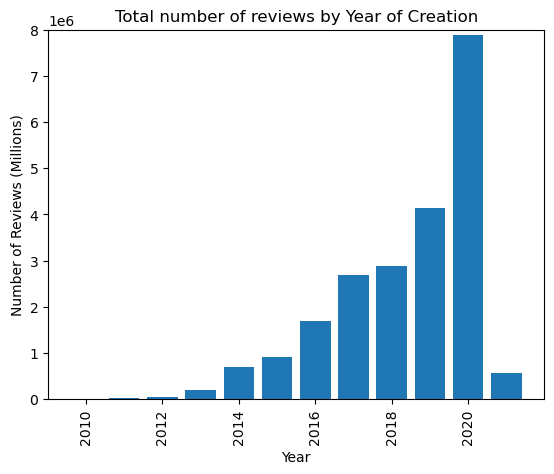

In [200]:
years_to_picture = reviews_by_year['year']
number_reviews = reviews_by_year['number_reviews']
width = 0.8

fig, ax = plt.subplots()
rects1 = ax.bar(years_to_picture, number_reviews, width)
ax.set_ylim(0,8000000)
ax.set_ylabel("Number of Reviews (Millions)")
ax.set_xlabel("Year")
ax.set_title("Total number of reviews by Year of Creation")
plt.xticks(rotation = 90)
plt.show()

#### Timestamp_updated: 

It refers to the date and hour on which the review was last updated

#### Recommended: 

It is a boolean feature and tells if the review recommends or not the app. 

In [206]:
recomm = pd.DataFrame(vaex_df['recommended'].value_counts()).reset_index()
recomm = recomm.rename(columns = {'index':'recommended',0:'number_reviews'})

In [212]:
recomm['perc']= round((recomm['number_reviews']/sum(recomm['number_reviews']))*100,1)
recomm

,recommended,number_reviews,perc
0,True,19022610,87.5
1,False,2724761,12.5


The vast majority of the reviews recommend the application they are reviewing. 

#### Votes_helpful: 

It indicates the number of votes that have classified the review as "helpful".



In [222]:
helpful_votes = pd.DataFrame(vaex_df['votes_helpful'].value_counts()).reset_index()

In [226]:
helpful_votes.sort_values(['index'])

,index,0
0,0,15642127
1,1,3478106
2,2,1083373
3,3,449848
4,4,235425
...,...,...
2497,26149,1
2225,28211,1
2472,29608,1
1789,4398046511104,1


#### Votes_funny: 

It indicates the number of votes that have classified the review as "funny"



In [228]:
funny_votes = pd.DataFrame(vaex_df['votes_funny'].value_counts()).reset_index()
funny_votes.sort_values(['index'])

,index,0
0,0,19144299
1,1,1719903
2,2,381143
3,3,144356
4,4,74835
...,...,...
726,4294967291,5
518,4294967292,10
378,4294967293,20
215,4294967294,58


#### Weighted_vote_score: 

In [234]:
weighted_score_df = pd.DataFrame(vaex_df['weighted_vote_score'].value_counts()).reset_index()
weighted_score_df = weighted_score_df.rename(columns = {'index':'weighted_score',0:'reviews'})

In [235]:
weighted_score_df.weighted_score.max()

0.995986759662628

#### Comment_count: 

#### Steam_purchase: 

#### Received_for_free: 

#### Written_during_early_access: 

#### Author.steamid: 

#### Author.num_games: 

#### Author.num_reviews: 

#### Author.playtime_forever: 

#### Author.playtime_last_two_weeks

#### Author.playtime_at_review

#### Author.last_played

# [RQ4]
### RQ4 - What are the top 3 languages used to review applications?

In [62]:
top_languages = pd.DataFrame(vaex_df['language'].value_counts()).reset_index()
top_languages = top_languages.rename(columns={'index': 'languages', 0: 'number_reviews'})

In [63]:
top_languages.head(3)

,languages,number_reviews
0,english,9635437
1,schinese,3764967
2,russian,2348900


The top 3 languages used to review applications are english, chinese and russian. 

### RQ4 - Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

In [64]:
def filter_languages_f(dataset_name, languages_to_filter):
    #check if languages_to_filter parameter is actually a list
    if(isinstance(languages_to_filter,list)):
        filtered_dataset = dataset_name[dataset_name['language'].isin(languages_to_filter)]
    else:
        print('Must enter the desired languages to be filtered in a list format')
    
    return filtered_dataset

In [65]:
filter_languages_f(vaex_df,['english','russian']).head(5)

#,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,3,292030,The Witcher 3: Wild Hunt,85184605,english,"""One of the best RPG's of all time, worthy of an...",2021-01-23 05:32:50,2021-01-23 05:32:50,True,0,0,0,0,True,False,False,76561199054755373,5,3,5587,3200,5524,1.61138e+09
1,5,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",2021-01-23 05:21:04,2021-01-23 05:21:04,True,0,0,0,0,True,False,False,76561198170193529,11,1,823,823,823,1.61138e+09
2,6,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",2021-01-23 05:18:11,2021-01-23 05:18:11,True,0,0,0,0,True,False,False,76561198119302812,27,2,4192,3398,4192,1.61135e+09
3,11,292030,The Witcher 3: Wild Hunt,85182372,russian,"'Шикарная игра с отличным сюжетом, неплохой граф...",2021-01-23 04:31:21,2021-01-23 04:31:21,True,0,0,0,0,True,False,False,76561198257031328,11,2,508,508,348,1.61139e+09
4,13,292030,The Witcher 3: Wild Hunt,85181146,russian,'Замечательная карточная игра в антураже фэнтези...,2021-01-23 03:57:18,2021-01-23 03:58:29,True,0,0,0,0,True,False,False,76561197987104694,501,23,7310,0,7310,1.52555e+09


### RQ4 - Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

In [70]:
filtered_languages = filter_languages_f(vaex_df,['english','russian','schinese'])
filtered_languages_funny = filtered_languages[filtered_languages['votes_funny'] != 0]
filtered_languages_funny = pd.DataFrame(filtered_languages_funny['language'].value_counts()).reset_index()
filtered_languages_funny = filtered_languages_funny.rename(columns={'index':'languages',0:'number_funny_reviews'})

In [67]:
filtered_languages_funny.head()

,languages,number_funny_reviews
0,english,1085997
1,schinese,444945
2,russian,391784


In [68]:
percent_funny = top_languages.merge(filtered_languages_funny)
percent_funny['percent_funny'] = round((percent_funny['number_funny_reviews']/percent_funny['number_reviews'])*100,1)
percent_funny

,languages,number_reviews,number_funny_reviews,percent_funny
0,english,9635437,1085997,11.3
1,schinese,3764967,444945,11.8
2,russian,2348900,391784,16.7


* Based on the last table, we can affirm that from the top 3 languages in terms of total number of reviews, the language with the most reviews categorized as funny is Russian, where 16.7% of the total reviews made in Russian were classified as funny at least once. 
* In the case of the reviews made in chinese and english language, 11.8% and 11.3% of the total reviews made in each language were classified as funny. 
* Based on this we could affirm that apparently even though russian reviews are not as numerous as the ones made in english, they in relative means funnier than those made in english. 

### RQ4 - Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [71]:
filtered_languages_helpful = filtered_languages[filtered_languages['votes_helpful'] != 0]
filtered_languages_helpful = pd.DataFrame(filtered_languages_helpful['language'].value_counts()).reset_index()
filtered_languages_helpful = filtered_languages_helpful.rename(columns={'index':'languages',0:'number_helpful_reviews'})

In [72]:
percent_helpful = top_languages.merge(filtered_languages_helpful)
percent_helpful['percent_helpful'] = round((percent_helpful['number_helpful_reviews']/percent_funny['number_reviews'])*100,1)
percent_helpful

,languages,number_reviews,number_helpful_reviews,percent_helpful
0,english,9635437,2813873,29.2
1,schinese,3764967,945157,25.1
2,russian,2348900,833896,35.5


## **************Missing interpretation!!

# [RQ7]

### RQ7 - What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?

In [260]:
www = vaex_df['weighted_vote_score'].to_pandas_series().to_frame().reset_index()
www = www.rename(columns = {0:'weighted_score'})
round((len(www[www['weighted_score']>=0.5])/len(www))*100,1)

22.0

The probability that a review has a weighted vote score equal or bigger than 0.5 is 22%. This is given by dividing the total number of reviews with a weighted_score greater or equal than 0.5 (the total number of successful occurences of the event we are studying) by the total number of reviews (the total number of possible outcomes). 

### RQ7 - What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?

This is a conditional probability where we can define:
* Event A: as the probability that a review has at least one vote as funny
* Event B: as the probability that a review has a Weighted vote score bigger than 0.5

The probability of A given B, P(A|B), can be computed as the probability of A and B, P(A intersection B), divided by the Probability of B. 

In [263]:
prob_event_b = round((len(www[www['weighted_score']>0.5])/len(www))*100,1)
prob_event_b

21.4

In [279]:
prob_event_a_b = round((len(vaex_df[(vaex_df.weighted_vote_score > 0.5) & (vaex_df.votes_funny >= 1)])/len(vaex_df))*100,1)
prob_event_a_b

5.3

In [280]:
prob_event_a_b/prob_event_b

0.24766355140186916

## Missing Interpretation!!

### RQ7 - Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?

In [284]:
len(vaex_df[vaex_df.votes_funny >= 1]) /len(vaex_df)

0.1196959393390585

If an Event A is independent of the Event B, this means that the P(A|B) = P(A). In this case this is not the case since the probability of P(A|B) is 24.7% and the P(A) is 11.9%. Therefore, the events are not independent. 